# Sales and Demand Prediction

###### One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately.

# 1. Data Exploration

In [62]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [63]:
#Importing the dataset

df = pd.read_csv(r"C:\Users\GUILLERMO\Desktop\Data Mining\CSV\Walmart.csv")
display(df.head())
original_df = df.copy(deep=True) # Copy DataFrame before....

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} observations.'.format(df.shape[1], df.shape[0]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11



Inference: The Dataset consists of 8 features & 6435 observations.


In [64]:
# Agregate some columns from date (Weekday, Month, year)

df.Date=pd.to_datetime(df.Date)
df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df.drop(['Date'], axis=1, inplace=True) 

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))    
df.columns = m

target = 'Weekly_Sales' # Our target Weekly Sales
features = [i for i in df.columns if i not in [target]]
all_features = [i for i in df.columns]

In [65]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.57,211.10,8.11,6,5,2010
1,1,1641957.44,1,38.51,2.55,211.24,8.11,3,12,2010
2,1,1611968.17,0,39.93,2.51,211.29,8.11,4,2,2010
3,1,1409727.59,0,46.63,2.56,211.32,8.11,4,2,2010
4,1,1554806.68,0,46.50,2.62,211.35,8.11,0,5,2010


In [66]:
df.tail()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
6430,45,713173.95,0,64.88,4.00,192.01,8.68,4,9,2012
6431,45,733455.07,0,64.89,3.98,192.17,8.67,3,5,2012
6432,45,734464.36,0,54.47,4.00,192.33,8.67,0,12,2012
6433,45,718125.53,0,56.47,3.97,192.33,8.67,4,10,2012
6434,45,760281.43,0,58.85,3.88,192.31,8.67,4,10,2012


In [67]:
print(features)

['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'weekday', 'month', 'year']


In [68]:
#Checking number of unique rows in each feature
df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [69]:
#Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [70]:
#Removal of any Duplicate rows (if any)

rs, cs = original_df.shape
df.drop_duplicates(inplace=True)
if df.shape[0]==(rs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [71]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = []; ncf = []; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])      
    else:nf.append(nu.index[i])
    
print('\n\033[1mInference:\033[0m The Dataset has {} numerical and {} categorical features.'.format(len(nf),len(cf)))


Inference: The Dataset has 4 numerical and 5 categorical features.


In [72]:
#Checking the stats of all the columns

display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Store,6435.00,23.00,12.99,1.00,12.00,23.00,34.00,45.00
Weekly_Sales,6435.00,1046964.88,564366.62,209986.25,553350.10,960746.04,1420158.66,3818686.45
Holiday_Flag,6435.00,0.07,0.26,0.00,0.00,0.00,0.00,1.00
Temperature,6435.00,60.66,18.44,-2.06,47.46,62.67,74.94,100.14
Fuel_Price,6435.00,3.36,0.46,2.47,2.93,3.44,3.73,4.47
CPI,6435.00,171.58,39.36,126.06,131.74,182.62,212.74,227.23
Unemployment,6435.00,8.00,1.88,3.88,6.89,7.87,8.62,14.31
weekday,6435.00,3.57,1.43,0.00,4.00,4.00,4.00,6.00
month,6435.00,6.48,3.32,1.00,4.00,6.00,9.00,12.00
year,6435.00,2010.97,0.80,2010.00,2010.00,2011.00,2012.00,2012.00


# 2. Exploratory Data Analysis (EDA)

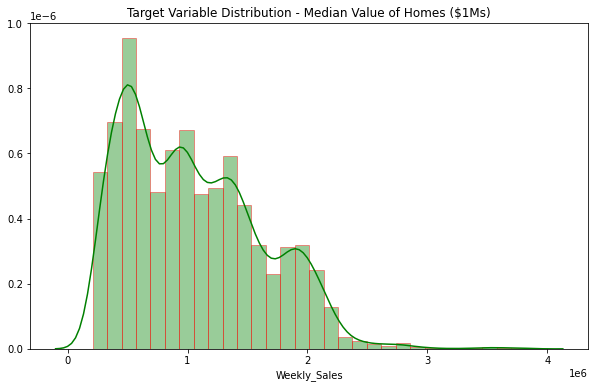

In [73]:
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="red", linewidth=1), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show() # analyze the distribution of the target variable

###### Inference: The Target Variable seems to be normally distributed.

# Univarate Analysis

Data type: Numeric and categoric
Note: Numeric variable can be continouse or dicrete, we can treat dicrete variable like ordinal variable(categorical) specially if it has limitted options (like number of children in family : it is numeric(discrete), so you can apply mean ,standard deviation and so on but you can treat it like categorical variable and for example draw bar chart for it or ...)
    
For categorical columns: for summarization: Freq, Mode, leveles     
                         for visualization: Bar chart or Pie chart

For numerical columns  : for summarization:Central tedency(mean, median, mode,...) and                        five_number_summary(min,Q1,median(Q2),Q3,Max), stdandard deviation ,...
                         for visualization:Histogram and dencity, Box plot,... 

Although ['Holiday Flag', 'year', 'weekday', 'month', 'Store']
are numerical column but beacuse it are discrete and has limitted options
we should better to treat it like categorical variable

In [74]:
# Getting the summary of Data
pd.options.display.float_format = "{:.2f}".format
df[cf].describe().T # for Categorical columns

,count,mean,std,min,25%,50%,75%,max
Holiday_Flag,6435.00,0.07,0.26,0.00,0.00,0.00,0.00,1.00
year,6435.00,2010.97,0.80,2010.00,2010.00,2011.00,2012.00,2012.00
weekday,6435.00,3.57,1.43,0.00,4.00,4.00,4.00,6.00
month,6435.00,6.48,3.32,1.00,4.00,6.00,9.00,12.00
Store,6435.00,23.00,12.99,1.00,12.00,23.00,34.00,45.00


                            Visualising as Categorical Distribution:                            


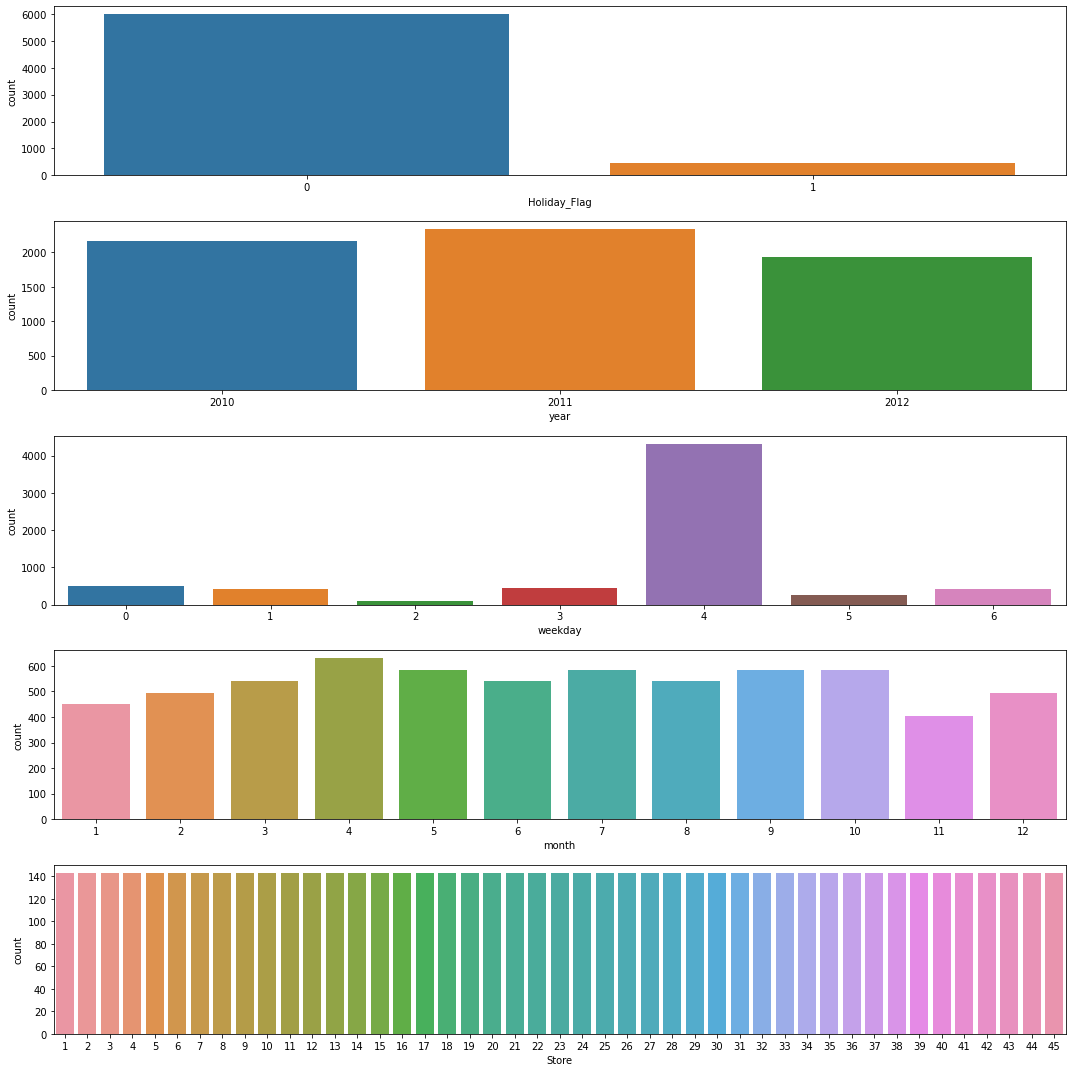

In [75]:
#Visualising the categorical features 

print('\033[1mVisualising as Categorical Distribution:'.center(100))

n=1
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf)/n),n,i+1)
    sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

In [76]:
df[cf].apply(lambda x:print(x.value_counts()))

0    5985
1     450
Name: Holiday_Flag, dtype: int64
2011    2340
2010    2160
2012    1935
Name: year, dtype: int64
4    4320
0     495
3     450
6     405
1     405
5     270
2      90
Name: weekday, dtype: int64
4     630
7     585
10    585
9     585
5     585
3     540
6     540
8     540
2     495
12    495
1     450
11    405
Name: month, dtype: int64
43    143
41    143
33    143
29    143
25    143
21    143
17    143
13    143
9     143
5     143
1     143
44    143
40    143
36    143
32    143
28    143
24    143
20    143
16    143
12    143
8     143
37    143
45    143
39    143
2     143
35    143
31    143
27    143
23    143
19    143
15    143
11    143
7     143
3     143
42    143
38    143
34    143
30    143
26    143
22    143
18    143
14    143
10    143
6     143
4     143
Name: Store, dtype: int64


Holiday_Flag    None
year            None
weekday         None
month           None
Store           None
dtype: object

In [77]:
# Getting the summary of Data
pd.options.display.float_format = "{:.2f}".format
df[nf].describe().T # for numeric columns

,count,mean,std,min,25%,50%,75%,max
Unemployment,6435.00,8.00,1.88,3.88,6.89,7.87,8.62,14.31
Fuel_Price,6435.00,3.36,0.46,2.47,2.93,3.44,3.73,4.47
CPI,6435.00,171.58,39.36,126.06,131.74,182.62,212.74,227.23
Temperature,6435.00,60.66,18.44,-2.06,47.46,62.67,74.94,100.14


                                                Numeric Features Distribution                                                 


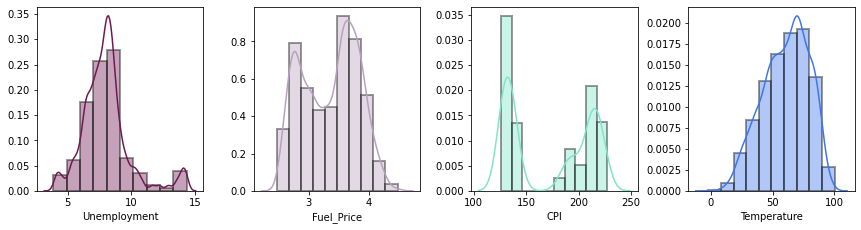

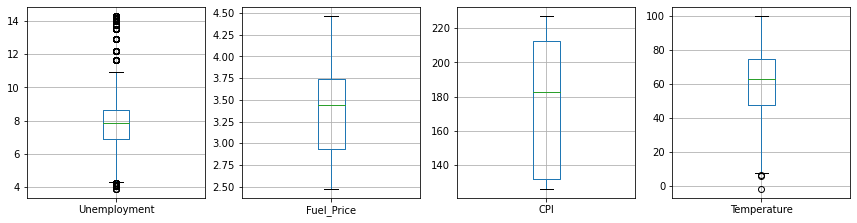

In [78]:
#Visualising the numeric features 
print('\033[1mNumeric Features Distribution'.center(130))
n=5

clr=['r','g','b','g','b','r']
plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

###### Inference: There seem to be some outliers. let us fix these in the upcoming section.

#Potential outliers are observations that lie outside the lower and upper limits.
Lower limit = Q1 - 1.5 * IQR
Upper limit = Q3 + 1.5 * IQR

1)lower inner fence: Q1 - 1.5*IQR
2)upper inner fence: Q3 + 1.5*IQR
3)lower outer fence: Q1 -   3*IQR
4)upper outer fence: Q3 +   3*IQR
Data values that lie between the inner and outer fences are considered possible outliers;  those that lie outside the outer fences are considered probable outliers or extreme outlier

In [79]:
def outlier_analysis(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    UIF=Q3+1.5*(IQR)
    LIF=Q1-1.5*(IQR)
    df_out =df[(df[col]<LIF) | (df[col]>UIF)] # I created a new data set that has just include potential outliers
    sns.distplot(df_out[col]) #Plotting univariate distributions.By default, this will draw a histogram and fit a kernel density estimate (KDE)
    return df_out[col] .describe()

count   481.00
mean     11.45
std       3.89
min       3.88
25%      11.63
50%      13.50
75%      14.02
max      14.31
Name: Unemployment, dtype: float64

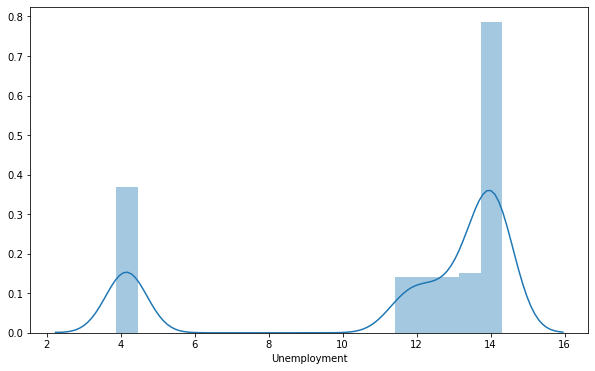

In [80]:
outlier_analysis('Unemployment')

count    3.00
mean     3.24
std      4.60
min     -2.06
25%      1.74
50%      5.54
75%      5.88
max      6.23
Name: Temperature, dtype: float64

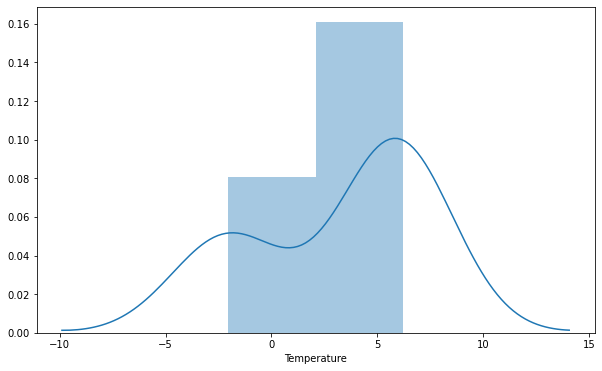

In [81]:
outlier_analysis('Temperature')

count        34.00
mean    3086723.36
std      379436.72
min     2727575.18
25%     2767649.33
50%     2913971.48
75%     3474992.09
max     3818686.45
Name: Weekly_Sales, dtype: float64

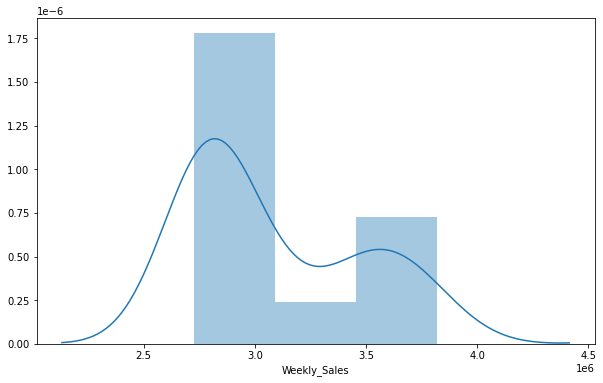

In [82]:
outlier_analysis('Weekly_Sales')

# Bivariate Analysis

In [83]:
df.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
Store,1.00,-0.34,0.00,-0.02,0.06,-0.21,0.22,0.00,0.00,0.00
Weekly_Sales,-0.34,1.00,0.04,-0.06,0.01,-0.07,-0.11,-0.02,0.07,-0.02
Holiday_Flag,0.00,0.04,1.00,-0.16,-0.08,-0.00,0.01,-0.09,0.33,-0.06
Temperature,-0.02,-0.06,-0.16,1.00,0.14,0.18,0.10,0.02,0.07,0.06
Fuel_Price,0.06,0.01,-0.08,0.14,1.00,-0.17,-0.03,-0.03,-0.05,0.78
CPI,-0.21,-0.07,-0.00,0.18,-0.17,1.00,-0.30,-0.01,0.00,0.07
Unemployment,0.22,-0.11,0.01,0.10,-0.03,-0.30,1.00,0.04,-0.00,-0.24
weekday,0.00,-0.02,-0.09,0.02,-0.03,-0.01,0.04,1.00,-0.14,-0.10
month,0.00,0.07,0.33,0.07,-0.05,0.00,-0.00,-0.14,1.00,-0.14
year,0.00,-0.02,-0.06,0.06,0.78,0.07,-0.24,-0.10,-0.14,1.00


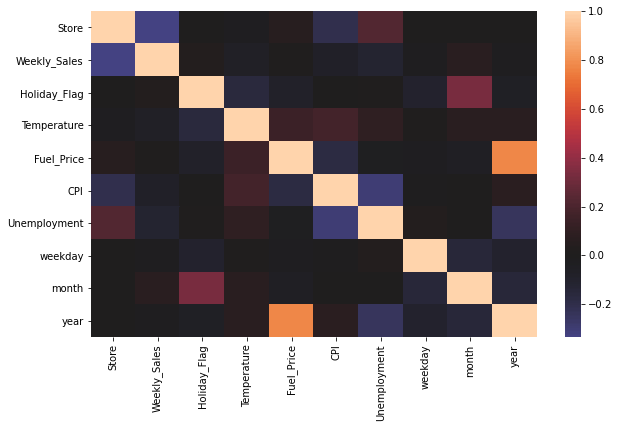

In [84]:
ht = sns.heatmap(df.corr(), center=0)

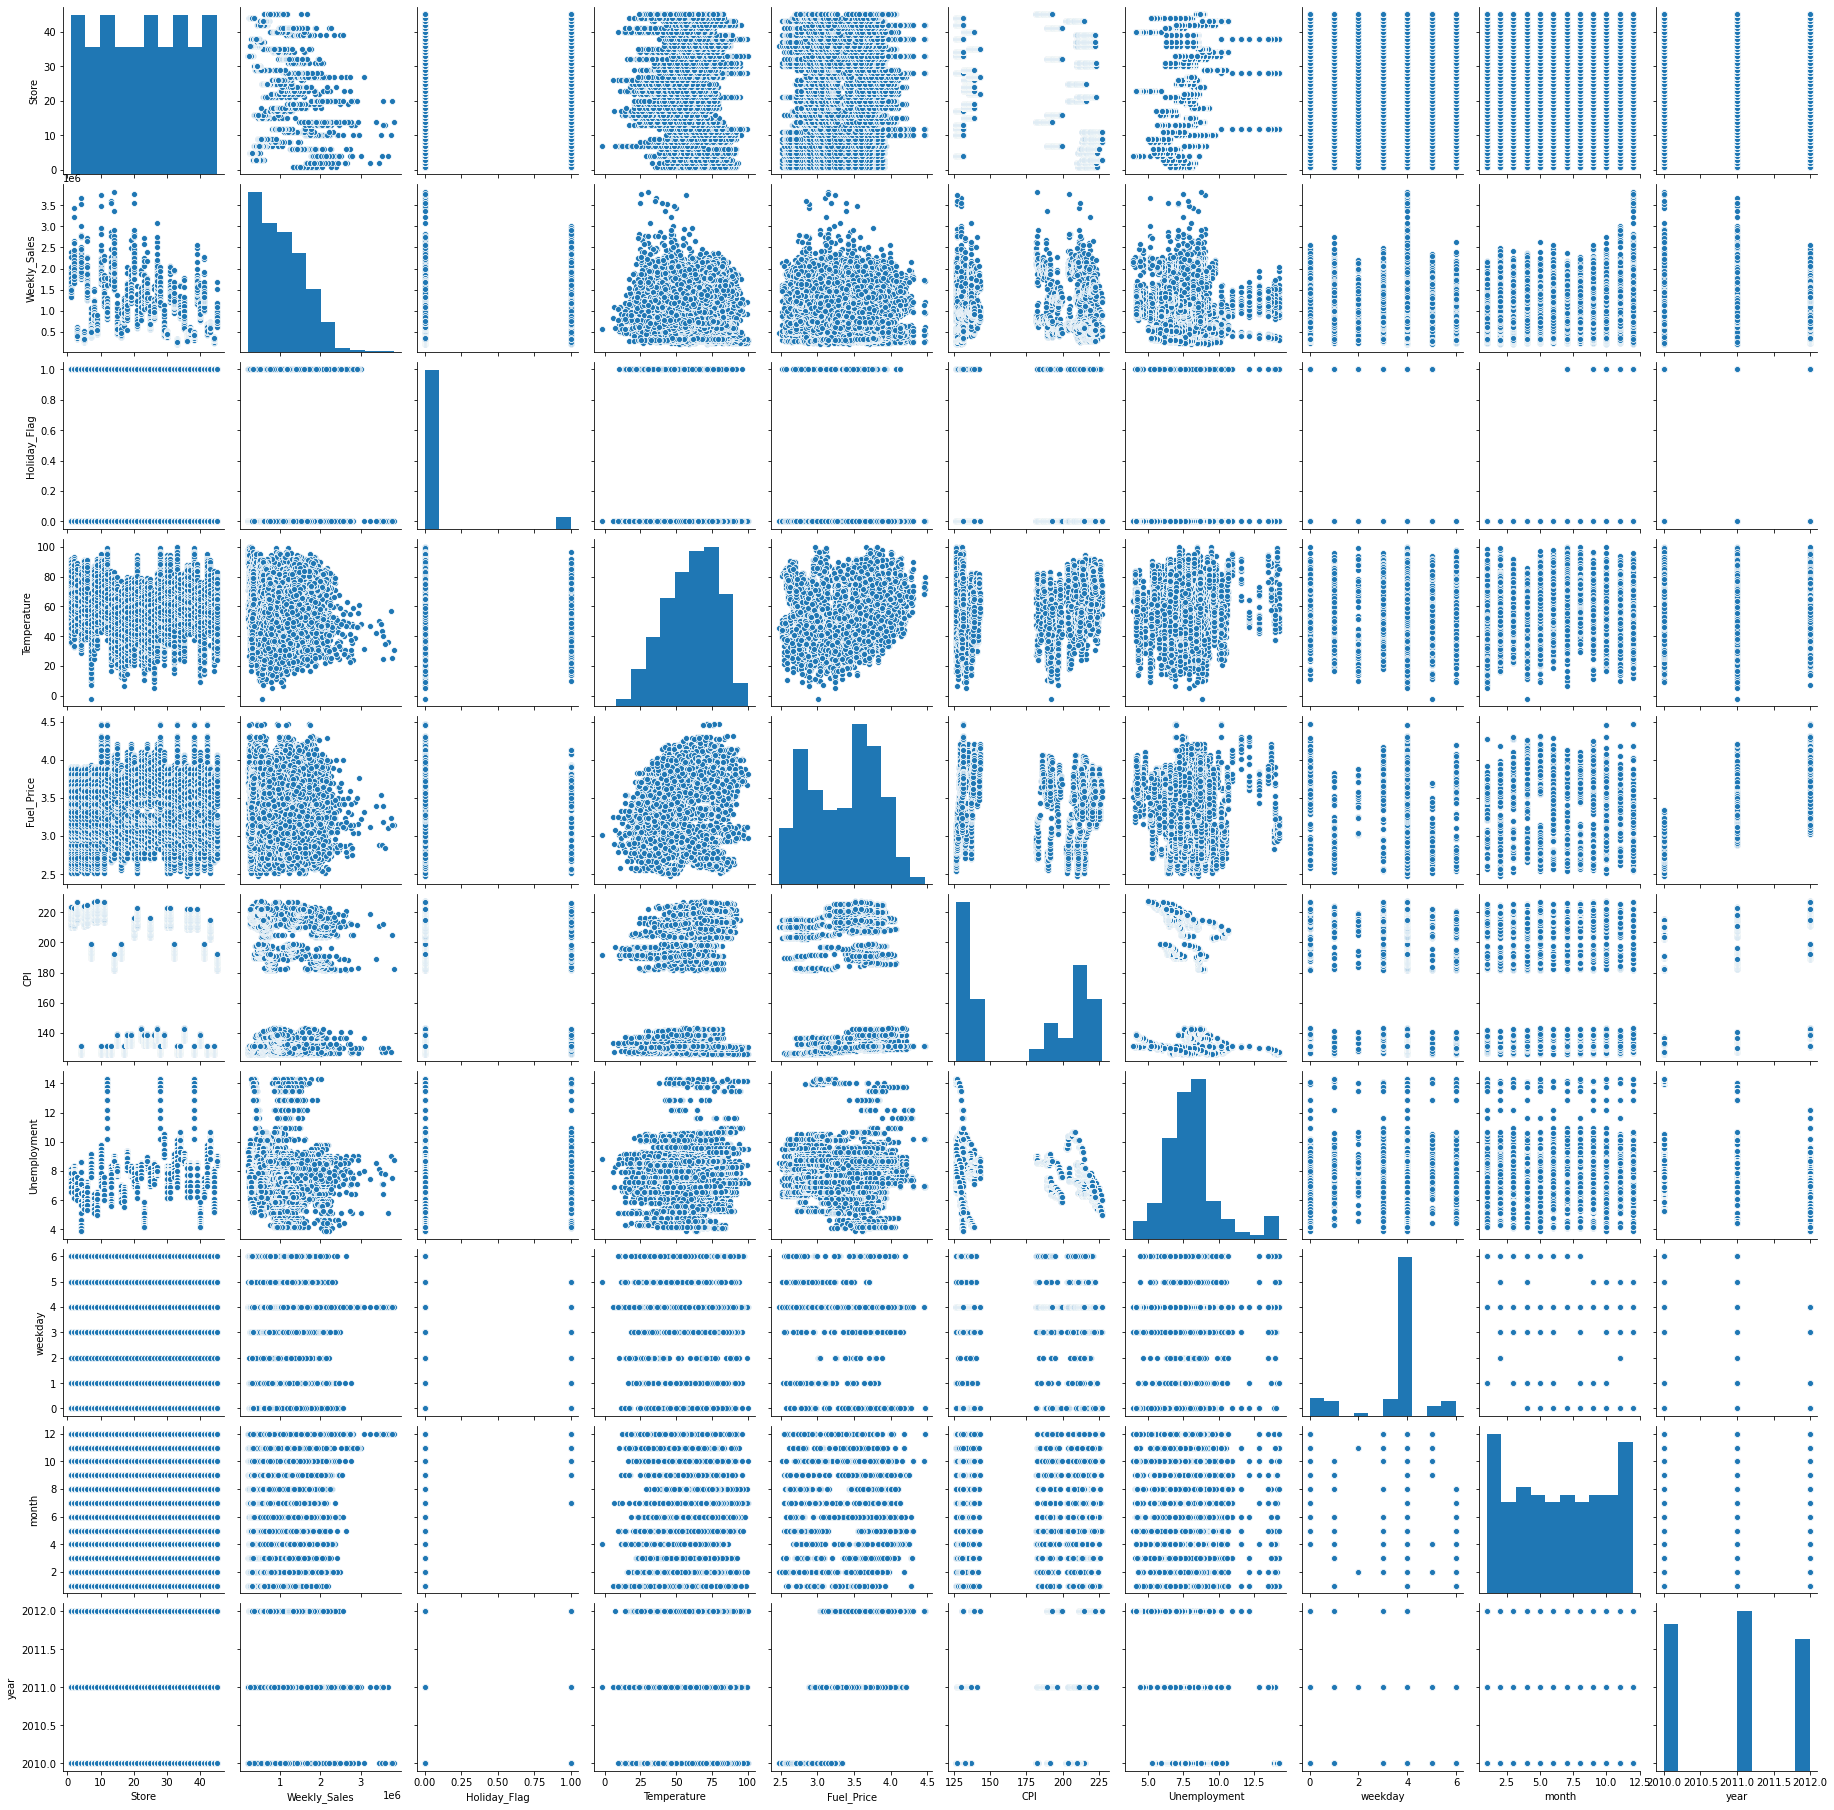

In [85]:
#Understanding the relationship between all the features

#g = sns.pairplot(df)
#plt.title('Pairplots for all the Feature')
#g.map_upper(sns.kdeplot, levels=2, color=".2")
#plt.show()

sns.pairplot(df) 

The Chi-square test statistic can be used if the following conditions are satisfied:

1.N, the total frequency, should be reasonably large, say greater than 50.
2. The sample observations should be independent. This implies that no individual item should be included twice or more in the sample.
3. No expected frequencies should be small. Small is a relative term. Preferably each expected frequencies should be larger than 10 but in any case not less than 5.


In [86]:
contingency_table = pd.crosstab(df['Store'],df['Holiday_Flag'],margins = True)
contingency_table

Holiday_Flag,0,1,All
Store,,,
1,133,10,143
2,133,10,143
3,133,10,143
4,133,10,143
5,133,10,143
6,133,10,143
7,133,10,143
8,133,10,143
9,133,10,143


In [87]:
from scipy.stats import chi2_contingency
def chi_square(c1,c2):
    chi_2, p_val, dof, exp_val = chi2_contingency(pd.crosstab(df[c1],df[c2],margins = False))# make sure margins = False

    print(exp_val)
    #print('\nChi-square is : %f'%chi_2, '\n\np_value is : %f'%p_val, '\n\ndegree of freedom is : %i'%dof)
    print(f'\nChi-square is : {chi_2}', f'\n\np_value is : {p_val}', f'\n\ndegree of freedom is :{dof}')

    if p_val < 0.05:# consider significan level is 5%
        print("\nThere is some correlation between the two variables at 0.05 significant level")
    else:
        print("\nThere is no correlation between the two variables")

In [88]:
chi_square("Store",'Holiday_Flag')

[[133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]
 [133.  10.]]

Chi-square is : 0.0 

p_value is : 1.0 

degree of freedom is :44

There is no correlation between the two variables


In [89]:
contingency_table = pd.crosstab(df['month'],df['Holiday_Flag'],margins = True)
contingency_table

Holiday_Flag,0,1,All
month,,,
1,450,0,450
2,495,0,495
3,540,0,540
4,630,0,630
5,585,0,585
6,540,0,540
7,540,45,585
8,540,0,540
9,540,45,585


In [90]:
chi_square("month",'Holiday_Flag')

[[418.53146853  31.46853147]
 [460.38461538  34.61538462]
 [502.23776224  37.76223776]
 [585.94405594  44.05594406]
 [544.09090909  40.90909091]
 [502.23776224  37.76223776]
 [544.09090909  40.90909091]
 [502.23776224  37.76223776]
 [544.09090909  40.90909091]
 [544.09090909  40.90909091]
 [376.67832168  28.32167832]
 [460.38461538  34.61538462]]

Chi-square is : 1093.4661654135339 

p_value is : 1.450621640630801e-227 

degree of freedom is :11

There is some correlation between the two variables at 0.05 significant level


In [91]:
contingency_table = pd.crosstab(df['year'],df['Holiday_Flag'],margins = True)
contingency_table

Holiday_Flag,0,1,All
year,,,
2010,1980,180,2160
2011,2160,180,2340
2012,1845,90,1935
All,5985,450,6435


In [92]:
chi_square("year",'Holiday_Flag')

[[2008.95104895  151.04895105]
 [2176.36363636  163.63636364]
 [1799.68531469  135.31468531]]

Chi-square is : 24.041703094946666 

p_value is : 6.017422493991033e-06 

degree of freedom is :2

There is some correlation between the two variables at 0.05 significant level


In [93]:
contingency_table = pd.crosstab(df['year'],df['month'],margins = True)
contingency_table

month,1,2,3,4,5,6,7,8,9,10,11,12,All
year,,,,,,,,,,,,,
2010,45,180,180,180,270,135,180,180,180,225,135,270,2160
2011,225,180,135,270,180,135,225,180,225,180,225,180,2340
2012,180,135,225,180,135,270,180,180,180,180,45,45,1935
All,450,495,540,630,585,540,585,540,585,585,405,495,6435


In [94]:
chi_square("year",'month')

[[151.04895105 166.15384615 181.25874126 211.46853147 196.36363636
  181.25874126 196.36363636 181.25874126 196.36363636 196.36363636
  135.94405594 166.15384615]
 [163.63636364 180.         196.36363636 229.09090909 212.72727273
  196.36363636 212.72727273 196.36363636 212.72727273 212.72727273
  147.27272727 180.        ]
 [135.31468531 148.84615385 162.37762238 189.44055944 175.90909091
  162.37762238 175.90909091 162.37762238 175.90909091 175.90909091
  121.78321678 148.84615385]]

Chi-square is : 558.654217512139 

p_value is : 4.0450086485230417e-104 

degree of freedom is :22

There is some correlation between the two variables at 0.05 significant level


In [95]:
contingency_table = pd.crosstab(df['year'],df['weekday'],margins = True)
contingency_table

weekday,0,1,2,3,4,5,6,All
year,,,,,,,,
2010,90,315,0,90,1350,180,135,2160
2011,90,45,90,180,1575,90,270,2340
2012,315,45,0,180,1395,0,0,1935
All,495,405,90,450,4320,270,405,6435


In [96]:
chi_square("year",'weekday')

[[ 166.15384615  135.94405594   30.20979021  151.04895105 1450.06993007
    90.62937063  135.94405594]
 [ 180.          147.27272727   32.72727273  163.63636364 1570.90909091
    98.18181818  147.27272727]
 [ 148.84615385  121.78321678   27.06293706  135.31468531 1299.02097902
    81.18881119  121.78321678]]

Chi-square is : 1227.2890019379845 

p_value is : 2.298950754203362e-255 

degree of freedom is :12

There is some correlation between the two variables at 0.05 significant level


In [97]:
contingency_table = pd.crosstab(df['Store'],df['weekday'],margins = True)
contingency_table

weekday,0,1,2,3,4,5,6,All
Store,,,,,,,,
1,11,9,2,10,96,6,9,143
2,11,9,2,10,96,6,9,143
3,11,9,2,10,96,6,9,143
4,11,9,2,10,96,6,9,143
5,11,9,2,10,96,6,9,143
6,11,9,2,10,96,6,9,143
7,11,9,2,10,96,6,9,143
8,11,9,2,10,96,6,9,143
9,11,9,2,10,96,6,9,143


In [98]:
chi_square("Store",'weekday')

[[11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9.  2. 10. 96.  6.  9.]
 [11.  9

In [99]:
df.groupby(['year']).agg({'Weekly_Sales':'describe'})

Weekly_Sales                                                     \
            count       mean       std       min       25%       50%   
year                                                                   
2010      2160.00 1059669.50 582386.10 209986.25 542321.28 974696.05   
2011      2340.00 1046239.32 569773.44 215359.21 555107.71 948390.02   
2012      1935.00 1033660.39 536653.46 236920.49 558529.36 960476.10   

                            
            75%        max  
year                        
2010 1415445.90 3818686.45  
2011 1421470.18 3676388.98  
2012 1426382.96 2565259.92

In [100]:
HL=df.groupby(['weekday']).agg({'Weekly_Sales':'describe'})
HL

Weekly_Sales                                                      \
               count       mean       std       min       25%        50%   
weekday                                                                    
0             495.00 1088915.66 575604.67 236157.12 582685.82 1004039.84   
1             405.00 1070388.78 568717.32 232769.09 570069.48 1001069.52   
2              90.00 1030142.40 547046.98 239198.36 556435.05  944618.89   
3             450.00 1059165.24 553936.02 258427.39 576249.56  984782.93   
4            4320.00 1038485.49 566078.26 209986.25 546687.04  950777.44   
5             270.00 1046276.68 548331.79 220060.35 556920.08  971562.94   
6             405.00 1053355.74 554345.54 224294.39 553836.98  963910.81   

                               
               75%        max  
weekday                        
0       1496007.19 2565259.92  
1       1466164.49 2752122.08  
2       1455934.55 2211388.14  
3       1454882.88 2495630.51  
4       1396690.98 3818686.45  
5       1398419.35 2351143.07  
6       1451953.95 2623469.95

In [101]:
HL=df.groupby(['weekday']).agg({'Temperature':'describe'})
HL

Temperature                                           
              count  mean   std   min   25%   50%   75%    max
weekday                                                       
0            495.00 59.44 17.01 11.17 45.35 59.21 72.80 100.07
1            405.00 61.21 18.77 16.60 46.74 63.63 77.33  95.88
2             90.00 55.73 26.34 10.24 30.83 53.38 77.74  99.20
3            450.00 63.63 18.40 18.14 48.78 65.89 77.63  96.00
4           4320.00 60.51 18.21  5.54 47.73 62.49 74.51 100.14
5            270.00 55.37 18.58 -2.06 42.93 57.53 66.08  93.52
6            405.00 64.64 18.82  9.55 54.08 69.24 77.49  97.66

In [102]:
HL=df.groupby(['month']).agg({'Temperature':'describe'})
HL

Temperature                                           
            count  mean   std   min   25%   50%   75%    max
month                                                       
1          450.00 49.47 20.47  5.54 32.70 49.12 66.98  98.43
2          495.00 50.21 18.06 15.64 35.98 48.77 61.41  99.20
3          540.00 57.41 16.00 21.88 45.34 56.55 69.55  92.13
4          630.00 56.87 15.19 -2.06 46.59 57.64 69.06  86.06
5          585.00 62.36 15.93  9.55 52.40 64.41 74.71  96.93
6          540.00 71.08 15.50 18.67 63.38 73.36 83.95  98.15
7          585.00 74.01 15.40  6.23 70.07 76.90 83.86 100.14
8          540.00 74.68 12.37 29.09 67.46 74.94 85.42  99.66
9          585.00 66.02 14.73 11.17 58.28 67.08 78.45  96.22
10         585.00 60.71 15.52 16.60 50.22 62.63 71.45 100.07
11         405.00 51.73 15.77 10.24 41.28 51.41 61.92  93.52
12         495.00 46.15 16.88 12.19 33.12 45.64 55.40  96.00

In [103]:
HL=df.groupby(['year']).agg({'Weekly_Sales':'describe'})
HL

Weekly_Sales                                                     \
            count       mean       std       min       25%       50%   
year                                                                   
2010      2160.00 1059669.50 582386.10 209986.25 542321.28 974696.05   
2011      2340.00 1046239.32 569773.44 215359.21 555107.71 948390.02   
2012      1935.00 1033660.39 536653.46 236920.49 558529.36 960476.10   

                            
            75%        max  
year                        
2010 1415445.90 3818686.45  
2011 1421470.18 3676388.98  
2012 1426382.96 2565259.92

In [104]:
HL=df.groupby(['Store']).agg({'Unemployment':'describe'})
HL

Unemployment                                         
             count  mean  std   min   25%   50%   75%   max
Store                                                      
1           143.00  7.61 0.38  6.57  7.35  7.79  7.84  8.11
2           143.00  7.62 0.62  6.17  7.06  7.93  8.10  8.32
3           143.00  7.18 0.45  6.03  6.83  7.35  7.56  7.57
4           143.00  5.96 1.42  3.88  4.61  5.95  7.13  8.62
5           143.00  6.30 0.39  5.42  5.94  6.49  6.53  6.77
6           143.00  6.61 0.53  5.33  6.13  6.86  6.97  7.26
7           143.00  8.59 0.43  7.56  8.26  8.62  8.96  9.14
8           143.00  6.09 0.36  5.12  5.83  6.29  6.32  6.43
9           143.00  6.10 0.46  4.95  5.67  6.38  6.42  6.56
10          143.00  8.36 0.84  6.94  7.54  8.49  9.00  9.77
11          143.00  7.18 0.45  6.03  6.83  7.35  7.56  7.57
12          143.00 13.12 1.21 10.20 12.19 13.74 14.10 14.31
13          143.00  7.00 0.88  5.62  6.10  7.19  7.79  8.32
14          143.00  8.65 0.15  8.42  8.52  8.62  8.72  8.99
15          143.00  8.00 0.19  7.66  7.81  8.07  8.15  8.35
16          143.00  6.48 0.35  5.85  6.17  6.34  6.84  7.04
17          143.00  6.55 0.33  5.53  6.40  6.63  6.77  6.88
18          143.00  8.84 0.44  8.07  8.47  8.97  9.27  9.34
19          143.00  8.00 0.19  7.66  7.81  8.07  8.15  8.35
20          143.00  7.37 0.31  6.96  7.14  7.29  7.48  8.19
21          143.00  7.62 0.62  6.17  7.06  7.93  8.10  8.32
22          143.00  8.07 0.37  7.50  7.71  8.25  8.43  8.57
23          143.00  4.80 0.55  4.12  4.26  4.78  5.29  5.89
24          143.00  8.45 0.29  8.12  8.21  8.33  8.66  8.98
25          143.00  7.37 0.31  6.96  7.14  7.29  7.48  8.19
26          143.00  7.87 0.41  7.14  7.49  7.82  8.15  8.51
27          143.00  8.00 0.16  7.72  7.85  8.01  8.06  8.25
28          143.00 13.12 1.21 10.20 12.19 13.74 14.10 14.31
29          143.00  9.81 0.52  8.99  9.36  9.97 10.26 10.52
30          143.00  7.62 0.62  6.17  7.06  7.93  8.10  8.32
31          143.00  7.62 0.62  6.17  7.06  7.93  8.10  8.32
32          143.00  8.59 0.43  7.56  8.26  8.62  8.96  9.14
33          143.00  8.53 0.96  6.89  7.60  8.69  9.27 10.12
34          143.00  9.93 0.48  8.84  9.57  9.82 10.40 10.64
35          143.00  8.79 0.18  8.51  8.68  8.76  8.86  9.26
36          143.00  7.87 0.70  6.23  7.24  8.30  8.39  8.55
37          143.00  7.87 0.70  6.23  7.24  8.30  8.39  8.55
38          143.00 13.12 1.21 10.20 12.19 13.74 14.10 14.31
39          143.00  7.87 0.70  6.23  7.24  8.30  8.39  8.55
40          143.00  4.80 0.55  4.12  4.26  4.78  5.29  5.89
41          143.00  6.97 0.40  6.20  6.59  6.93  7.33  7.54
42          143.00  8.36 0.84  6.94  7.54  8.49  9.00  9.77
43          143.00  9.93 0.48  8.84  9.57  9.82 10.40 10.64
44          143.00  6.74 0.96  5.22  5.77  6.91  7.61  8.12
45          143.00  8.65 0.15  8.42  8.52  8.62  8.72  8.99

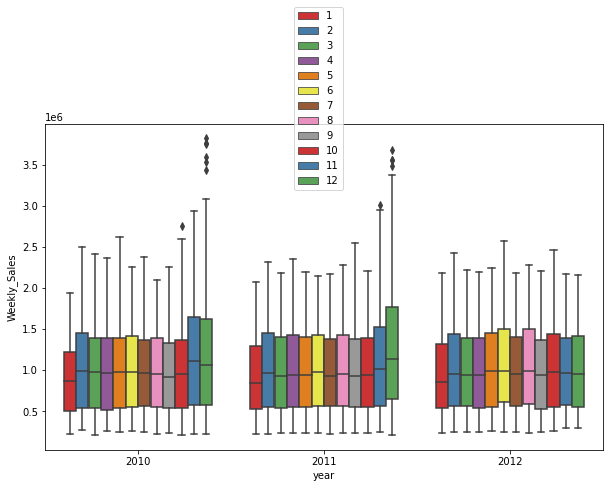

In [105]:
ax = sns.boxplot(x="year", y="Weekly_Sales", hue="month",
               data=df, palette="Set1")
ax.legend(loc=4,borderaxespad=26)

In [106]:
dfa=df.drop(df[df['Weekly_Sales'].isnull()].index)

In [107]:
import scipy.stats as stats

stats.f_oneway(dfa['Weekly_Sales'][dfa['year'] == 2010],
               dfa['Weekly_Sales'][dfa['year'] == 2011],
               dfa['Weekly_Sales'][dfa['year'] == 2012])

F_onewayResult(statistic=1.0869428927869191, pvalue=0.33730785415347436)

###### Before the results should be interpreted, the assumptions of the test should be checked. 

In [108]:
stats.levene(dfa['Weekly_Sales'][dfa['year'] == 2010],
             dfa['Weekly_Sales'][dfa['year'] == 2011],
             dfa['Weekly_Sales'][dfa['year'] == 2012])

LeveneResult(statistic=2.7419146395166947, pvalue=0.06452216664725613)

In [109]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Missing Values'])
nvc['Percentage Missing Values'] = round(nvc['Total Missing Values']/df.shape[0],3)*100
nvc['Unique Value'] = df.nunique().sort_values()
nvc['Duplicated'] = df.duplicated().sum()
print(nvc)

              Total Missing Values  Percentage Missing Values  Unique Value  \
Store                            0                       0.00            45   
Weekly_Sales                     0                       0.00          6435   
Holiday_Flag                     0                       0.00             2   
Temperature                      0                       0.00          3528   
Fuel_Price                       0                       0.00           892   
CPI                              0                       0.00          2145   
Unemployment                     0                       0.00           349   
weekday                          0                       0.00             7   
month                            0                       0.00            12   
year                             0                       0.00             3   

              Duplicated  
Store                  0  
Weekly_Sales           0  
Holiday_Flag           0  
Temperature           

In [110]:
#Converting categorical Columns to Numeric
df3 = df.copy()

ecc = nvc[nvc['Percentage Missing Values']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        


One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
year
weekday
month
Store


In [111]:
#Removal of outlier:
df1 = df3.copy()
features1 = nf
for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())

df_target=df3[target]
df_target = df_target.to_numpy()

df_features=df3
df_features = df_features.to_numpy()


print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.57,211.10,8.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.55,211.24,8.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.51,211.29,8.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.56,211.32,8.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.62,211.35,8.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


In [112]:
#Final Dataset size after performing Preprocessing
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

In [113]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 68) (5953,) 
Training set  --->  (4762, 68) (4762,) 
Testing set   --->  (1191, 68)  (1191,)


In [114]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,...,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00,4762.00
mean,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.27,-2.96,-1.87,-1.25,-2.76,-0.75,-0.64,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
25%,-0.27,-0.73,-0.99,-1.08,-0.68,-0.75,-0.64,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
50%,-0.27,0.11,0.17,0.38,0.10,-0.75,-0.64,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
75%,-0.27,0.77,0.84,0.99,0.61,1.33,1.57,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
max,3.65,2.17,2.47,1.34,2.58,1.33,1.57,3.86,8.64,3.68,...,6.36,6.30,22.98,6.33,7.65,6.50,6.36,6.14,6.44,6.56



                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,...,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00,1191.00
mean,0.01,0.04,0.08,0.02,-0.05,0.05,0.07,0.01,0.04,0.03,...,-0.00,-0.02,0.11,-0.01,-0.00,0.03,-0.00,-0.06,0.02,0.05
std,1.01,1.00,0.97,1.00,1.01,1.01,1.03,1.01,1.15,1.04,...,0.99,0.94,1.88,0.97,1.00,1.09,0.99,0.81,1.05,1.13
min,-0.27,-2.86,-1.78,-1.25,-2.76,-0.75,-0.64,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
25%,-0.27,-0.66,-0.85,-1.08,-0.70,-0.75,-0.64,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
50%,-0.27,0.19,0.30,0.39,0.06,-0.75,-0.64,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
75%,-0.27,0.82,0.84,1.02,0.61,1.33,1.57,-0.26,-0.12,-0.27,...,-0.16,-0.16,-0.04,-0.16,-0.13,-0.15,-0.16,-0.16,-0.16,-0.15
max,3.65,2.04,2.47,1.35,2.58,1.33,1.57,3.86,8.64,3.68,...,6.36,6.30,22.98,6.33,7.65,6.50,6.36,6.14,6.44,6.56


                                       Correlation Matrix                                       


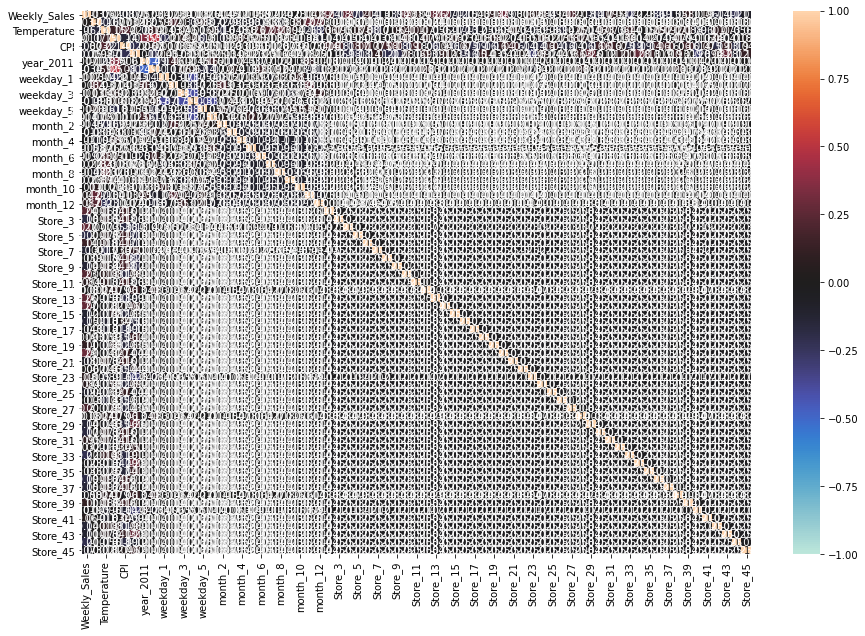

In [115]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[15, 10])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [116]:
#Testing a Linear Regression model with statsmodels
Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     958.4
Date:                Thu, 13 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:53:16   Log-Likelihood:                -63430.
No. Observations:                4762   AIC:                         1.270e+05
Df Residuals:                    4693   BIC:                         1.274e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.048e+06   2152.234    486.752      0.000    1.04e+06    1.05e+06
Holiday_Flag  3435.7934   2436.850      1.410      0.159   -1341.577    8213.164
Temperature  -1.091e+04   3611.329     -3.022      0.003    -1.8e+04   -3834.746
Fuel_Price    4743.1404   6083.604      0.780      0.436   -7183.581    1.67e+04
CPI           4.806e+05   6.53e+04      7.359      0.000    3.53e+05    6.09e+05
Unemployment -6.096e+04   7305.771     -8.344      0.000   -7.53e+04   -4.66e+04
year_2011    -3.085e+04   6385.220     -4.832      0.000   -4.34e+04   -1.83e+04
year_2012    -7.005e+04   8794.662     -7.965      0.000   -8.73e+04   -5.28e+04
weekday_1     5298.1880   3028.935      1.749      0.080    -639.948    1.12e+04
weekday_2    -1.144e+04   2552.678     -4.481      0.000   -1.64e+04   -6435.135
weekday_3    -1.397e+04   3035.015     -4.603      0.000   -1.99e+04   -8021.037
weekday_4    -1.668e+04   4056.274     -4.113      0.000   -2.46e+04   -8730.185
weekday_5    -1.288e+04   2827.562     -4.555      0.000   -1.84e+04   -7335.388
weekday_6    -2292.8321   3074.313     -0.746      0.456   -8319.930    3734.265
month_2       2.869e+04   3169.875      9.050      0.000    2.25e+04    3.49e+04
month_3       2.018e+04   3233.395      6.243      0.000    1.38e+04    2.65e+04
month_4       2.099e+04   3462.153      6.062      0.000    1.42e+04    2.78e+04
month_5       2.214e+04   3478.401      6.364      0.000    1.53e+04     2.9e+04
month_6       3.159e+04   3270.641      9.659      0.000    2.52e+04     3.8e+04
month_7       1.905e+04   3478.984      5.474      0.000    1.22e+04    2.59e+04
month_8       2.445e+04   3357.585      7.282      0.000    1.79e+04     3.1e+04
month_9       1.231e+04   3456.199      3.561      0.000    5531.812    1.91e+04
month_10      1.696e+04   3519.751      4.820      0.000    1.01e+04    2.39e+04
month_11      4.132e+04   3243.964     12.736      0.000     3.5e+04    4.77e+04
month_12      6.241e+04   3556.769     17.546      0.000    5.54e+04    6.94e+04
Store_2       5.522e+04   2977.883     18.545      0.000    4.94e+04    6.11e+04
Store_3      -1.841e+05   3122.600    -58.973      0.000    -1.9e+05   -1.78e+05
Store_4       2.173e+05   2.14e+04     10.161      0.000    1.75e+05    2.59e+05
Store_5      -1.914e+05   3140.260    -60.961      0.000   -1.98e+05   -1.85e+05
Store_6      -9300.0797   3167.398     -2.936      0.003   -1.55e+04   -3090.492
Store_7      -1.058e+05   6373.008    -16.605      0.000   -1.18e+05   -9.33e+04
Store_8       -1.21e+05   3457.789    -34.980      0.000   -1.28e+05   -1.14e+05
Store_9      -1.635e+05   3269.593    -50.014      0.000    -1.7e+05   -1.57e+05
Store_10       2.18e+05   2.21e+04      9.844      0.000    1.75e+05    2.61e+05
Store_11     -4.043e+04   3138.072    -12.885      0.000   -4.66e+04   -3.43e+04
Store

In [117]:
#Let us first define a function to evaluate our models
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), 
                                                  columns=['Train-R2',
                                                           'Test-R2','Train-RSS',
                                                           'Test-RSS',
                                                           'Train-MSE',
                                                           'Test-MSE',
                                                           'Train-RMSE',
                                                           'Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                        
    plt.show()



<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


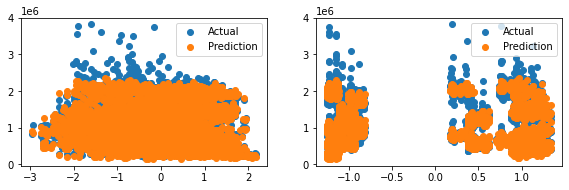



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9328296106281632
Residual Sum of Squares (RSS) on Training set  ---> 103518718391842.17
Mean Squared Error (MSE) on Training set       ---> 21738496092.36501
Root Mean Squared Error (RMSE) on Training set ---> 147439.8049794051

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9303017696577066
Residual Sum of Squares (RSS) on Training set  ---> 28393614754891.723
Mean Squared Error (MSE) on Training set       ---> 23840146729.54805
Root Mean Squared Error (RMSE) on Training set ---> 154402.54767829465

--------------------Residual Plots--------------------


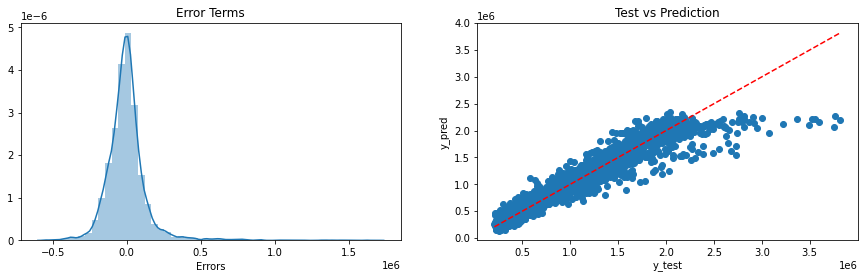

In [118]:
#Linear Regression
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(0, pred1, pred2)

In [119]:
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 3: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 2: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 5: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 4: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
        
    linear_assumption()
    multicollinearity_assumption()
    normal_errors_assumption()
    homoscedasticity_assumption()
    autocorrelation_assumption()

Fitting linear regression

R^2: 1.0 

Coefficients
-------------------------------------
Intercept: 2.3283064365386963e-10
X1: 1.000000000000001
X2: -4.2291674110001095e-11
X3: -1.657319528292822e-12
X4: -1.0987944711575166e-10
X5: -5.247419188031767e-12
X6: 1.6301191389725157e-11
X7: 8.470775326637785e-11
X8: 2.302319485773092e-10
X9: 7.801428822001103e-12
X10: 5.048290879798705e-11
X11: 2.9551722429668076e-11
X12: 2.133343462724157e-11
X13: 1.976581129984241e-11
X14: 1.3287094948888388e-10
X15: -1.9977292290603224e-12
X16: 9.861689276386276e-12
X17: 2.1519838376246123e-11
X18: 8.429514002923637e-11
X19: 2.442245567245918e-11
X20: 3.6161466198189025e-11
X21: 3.332626395947882e-11
X22: 4.3375700016296514e-11
X23: 3.3985871335644823e-11
X24: 1.9462594493925675e-11
X25: 1.6215219765088593e-11
X26: -2.7911036779799255e-10
X27: -2.2604514717631022e-10
X28: -5.995625750893496e-10
X29: -2.1963316434820482e-10
X30: -2.619001218572697e-10
X31: -3.519619236206449e-10
X32: -2.421593021828145e-10

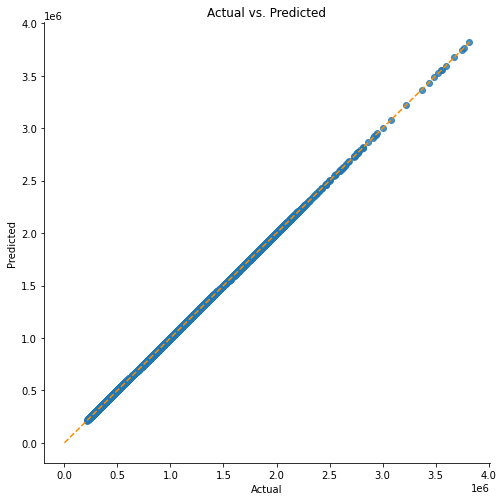

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: Little to no multicollinearity among predictors


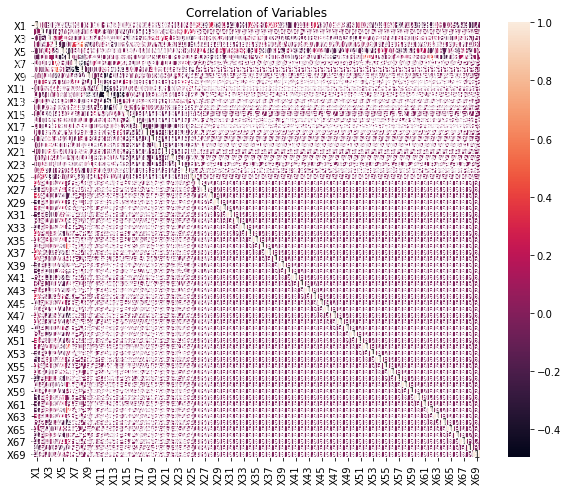

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X1: 65.39449170228812
X2: 1.3822634855183706
X3: 31.85786049258648
X4: 426.40556194119745
X5: 575.1216328354332
X6: 394.3853821011277
X7: 10.40458035223568
X8: 14.025237890132836
X9: 2.126549213469685
X10: 1.4297857474514584
X11: 2.1070178294377633
X12: 10.739717823548688
X13: 1.7619492938499974
X14: 2.148254401847166
X15: 2.339535989587158
X16: 2.4333591995613153
X17: 2.8119635479337934
X18: 2.794098694247151
X19: 2.567175613340113
X20: 2.84027247520438
X21: 2.6727844563137153
X22: 2.7246546072154327
X23: 2.704450761127391
X24: 2.4163257261512032
X25: 2.8906080812406727
X26: 2.138189156339483
X27: 3.556467392170194
X28: 4.197891804674705
X29: 3.975435534501216
X30: 2.1570062422350236
X31: 3.0100557750221415
X32: 2.975260191641849
X33: 3.6590366364013356
X34: 6.415370575255782
X35: 2.1349907874615233
X36: 1

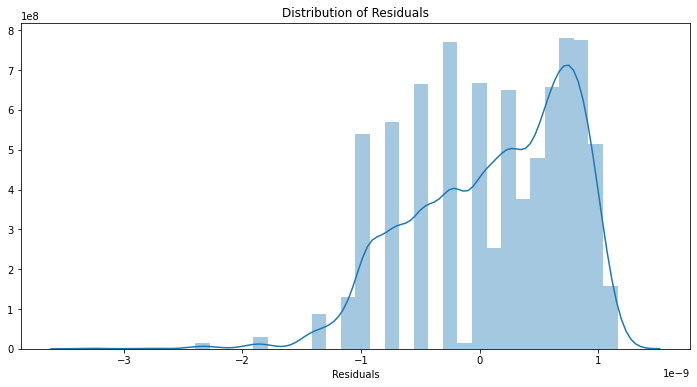


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 4: Homoscedasticity of Error Terms
Residuals should have relative constant variance


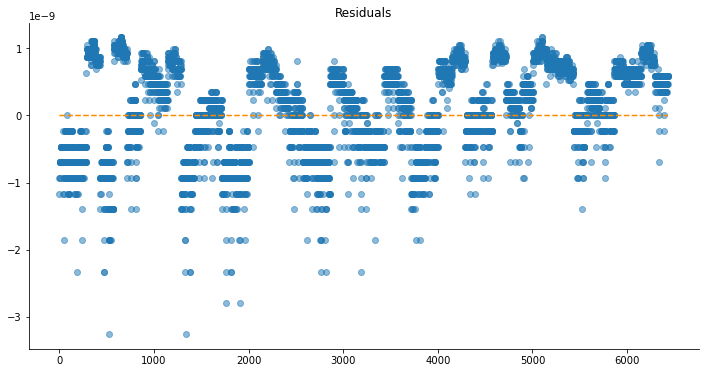

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

Assumption 5: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.14688414578900738
Signs of positive autocorrelation 

Assumption not satisfied 

Consider adding lag variables


In [120]:
linear_regression_assumptions(df_features,df_target)